In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")



In [ ]:
test_data.head()

<ipython-input-11-eb4efc411288>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = test_data.corr()


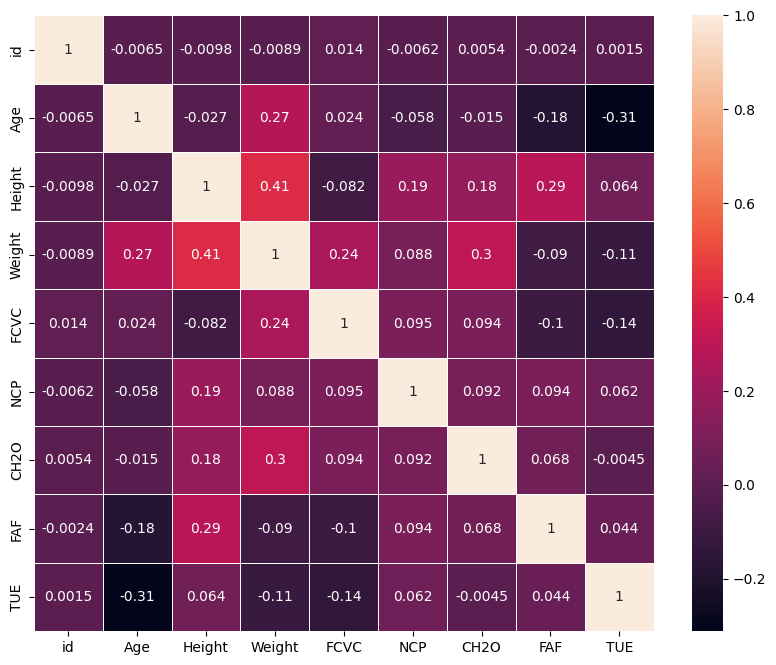

In [ ]:
# prompt: genrate a corelation heat map

import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = test_data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)

plt.show()


In [ ]:
# prompt: tell me the features which are corelated more than 0.38

correlated_features = corr_matrix[corr_matrix > 0.35].stack().reset_index()
correlated_features.columns = ['feature1', 'feature2', 'correlation']
correlated_features = correlated_features[correlated_features['feature1'] != correlated_features['feature2']]

print(correlated_features)


  feature1 feature2  correlation
3   Height   Weight     0.412988
4   Weight   Height     0.412988


In [ ]:
# prompt: check null values

train_data.isnull().sum()


id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

def perform_feature_engineering(df):
    # Age Group
    age_bins = [0, 18, 30, 40, 50, 80]
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=False, right=False)

    # BMI (Body Mass Index)
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

    # Technology Usage Category
    tech_bins = [0, 1, 2, 3]
    df['TechnologyUsageCategory'] = pd.cut(df['TUE'], bins=tech_bins, labels=False, right=False)

    # Physical Activity Level (Low, Medium, High)
    activity_bins = [0, 1, 2, np.inf]
    df['ActivityLevel'] = pd.cut(df['FAF'], bins=activity_bins, labels=['Low', 'Medium', 'High'], right=False)

    # Assuming that people who eat fewer meals are more likely to be obese, dividing BMI by NCP (number of main meals)
    df['bmioncp'] = df['BMI'] / df['NCP']

    # Derive Water Intake Ratio (WIR)
    df['WIR'] = df['Weight'] / df['CH2O']

    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

    df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'no':0, 'yes':1})

    df['FAVC'] = df['FAVC'].map({'no':0, 'yes':1})

    df['CAEC'] = df['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    df['SMOKE'] = df['SMOKE'].map({'no':0, 'yes':1})

    df['SCC'] = df['SCC'].map({'no':0, 'yes':1})

    df['CALC'] = df['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    return df


# Apply the function to the training data
train_data = perform_feature_engineering(train_data)

# Apply the function to the test data
test_data = perform_feature_engineering(test_data)

In [ ]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,...,TUE,CALC,MTRANS,NObeyesdad,AgeGroup,BMI,TechnologyUsageCategory,ActivityLevel,bmioncp,WIR
0,0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,...,0.976473,1,Public_Transportation,Overweight_Level_II,1,28.259565,0,Low,9.472595,29.552304
1,1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,...,1.000000,0,Automobile,Normal_Weight,1,23.422091,1,Medium,7.807364,28.500000
2,2,1,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,...,1.673584,0,Public_Transportation,Insufficient_Weight,1,17.126706,1,Low,12.132102,26.259596
3,3,1,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,...,0.780199,1,Public_Transportation,Obesity_Type_III,1,44.855798,0,Medium,14.951933,78.417006
4,4,0,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,...,0.931721,1,Public_Transportation,Overweight_Level_II,2,25.599151,0,Medium,12.984791,47.376392


In [ ]:
columns_to_drop = ['id']
train_data.drop(columns_to_drop, axis=1, inplace=True)


In [ ]:
numerical_variables = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'bmioncp', 'WIR', 'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC']
target_variable = 'NObeyesdad'
categorical_variables = ['MTRANS', 'AgeGroup', 'TechnologyUsageCategory', 'ActivityLevel']

In [ ]:
columns_to_check = [var for var in numerical_variables if var not in ['BMI','bmioncp','WIR','Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC']]

In [ ]:
print(columns_to_check)

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


In [ ]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.1)
    Q3 = data[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    # Calculate the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)

    return filtered_data, rows_deleted



In [ ]:
rows_deleted_total=0
for column in columns_to_check:
    train_data, rows_deleted = remove_outliers_iqr(train_data, column)
    rows_deleted_total += rows_deleted
    print(f"Rows deleted for {column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

Rows deleted for Age: 67
Rows deleted for Height: 0
Rows deleted for Weight: 0
Rows deleted for FCVC: 0
Rows deleted for NCP: 0
Rows deleted for CH2O: 0
Rows deleted for FAF: 0
Rows deleted for TUE: 0
Total rows deleted: 67


In [ ]:
y = train_data['NObeyesdad']
id_test = test_data['id']
test_data.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
skewed_features = train_data[columns_to_check].skew()[train_data[columns_to_check].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Apply log1p transformation to skewed features
train_data[skewed_features] = np.log1p(train_data[skewed_features])

Features to be transformed (skewness > 0.75):


array(['Age'], dtype=object)

In [ ]:
skewed_features = test_data[columns_to_check].skew()[test_data[columns_to_check].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Apply log1p transformation to skewed features
test_data[skewed_features] = np.log1p(test_data[skewed_features])

Features to be transformed (skewness > 0.75):


array(['Age'], dtype=object)

In [ ]:
train_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,TUE,CALC,MTRANS,NObeyesdad,AgeGroup,BMI,TechnologyUsageCategory,ActivityLevel,bmioncp,WIR
0,0,3.236441,1.699998,81.669950,1,1,2.000000,2.983297,1,0,...,0.976473,1,Public_Transportation,Overweight_Level_II,1,28.259565,0,Low,9.472595,29.552304
1,1,2.944439,1.560000,57.000000,1,1,2.000000,3.000000,2,0,...,1.000000,0,Automobile,Normal_Weight,1,23.422091,1,Medium,7.807364,28.500000
2,1,2.944439,1.711460,50.165754,1,1,1.880534,1.411685,1,0,...,1.673584,0,Public_Transportation,Insufficient_Weight,1,17.126706,1,Low,12.132102,26.259596
3,1,3.088892,1.710730,131.274851,1,1,3.000000,3.000000,1,0,...,0.780199,1,Public_Transportation,Obesity_Type_III,1,44.855798,0,Medium,14.951933,78.417006
4,0,3.485572,1.914186,93.798055,1,1,2.679664,1.971472,1,0,...,0.931721,1,Public_Transportation,Overweight_Level_II,2,25.599151,0,Medium,12.984791,47.376392


In [ ]:
# Selecting specific columns for encoding
columns_to_encode = categorical_variables.copy()
train_data_to_encode = train_data[columns_to_encode]
test_data_to_encode = test_data[columns_to_encode]

# Dropping selected columns for scaling
train_data_to_scale = train_data.drop(columns_to_encode, axis=1)
test_data_to_scale = test_data.drop(columns_to_encode, axis=1)

In [ ]:
# Use pandas get_dummies to one-hot encode 'Geography' and 'Gender' in train_data
train_data_encoded = pd.get_dummies(train_data_to_encode, columns=columns_to_encode, drop_first=True)

# Use pandas get_dummies to one-hot encode 'Geography' and 'Gender' in test_data
test_data_encoded = pd.get_dummies(test_data_to_encode, columns=columns_to_encode, drop_first=True)

In [ ]:
train_data_encoded.head()

,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,TechnologyUsageCategory_1,TechnologyUsageCategory_2,ActivityLevel_Medium,ActivityLevel_High
0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,1,0


In [ ]:
train_data_to_scale.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,BMI,bmioncp,WIR
0,0,3.236441,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,Overweight_Level_II,28.259565,9.472595,29.552304
1,1,2.944439,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,Normal_Weight,23.422091,7.807364,28.500000
2,1,2.944439,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,Insufficient_Weight,17.126706,12.132102,26.259596
3,1,3.088892,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,Obesity_Type_III,44.855798,14.951933,78.417006
4,0,3.485572,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,Overweight_Level_II,25.599151,12.984791,47.376392


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(train_data_to_scale.drop(['NObeyesdad'], axis=1))

# Scale the training data
scaled_data_train = minmax_scaler.transform(train_data_to_scale.drop(['NObeyesdad'], axis=1))
scaled_train_df = pd.DataFrame(scaled_data_train, columns=train_data_to_scale.drop(['NObeyesdad'], axis=1).columns)

# Scale the test data using the parameters from the training data
scaled_data_test = minmax_scaler.transform(test_data_to_scale)
scaled_test_df = pd.DataFrame(scaled_data_test, columns=test_data_to_scale.columns)

In [ ]:
scaled_train_df.head()

In [ ]:
# Concatenate train datasets
train_data_combined = pd.concat([train_data_encoded.reset_index(drop=True), scaled_train_df.reset_index(drop=True)], axis=1)

# Concatenate test datasets
test_data_combined = pd.concat([test_data_encoded.reset_index(drop=True), scaled_test_df.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_data_combined['NObeyesdad'] = label_encoder.fit_transform(y)

In [ ]:
train_data_combined.head()

In [ ]:
train_data_combined.shape

In [ ]:
test_data_combined.shape

In [ ]:
numeric_cols = train_data_combined.select_dtypes(include=['number', 'bool'])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Create a heatmap using Seaborn with smaller font size for annotations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Plot of Numeric Columns in train_data_combined')
plt.show()

In [ ]:
X = train_data_combined.drop('NObeyesdad',axis=1)
y = train_data_combined['NObeyesdad']

In [ ]:
# prompt: save the train_data_combined and test_data_combined in disk

train_data_combined.to_csv('train_processed.csv')
test_data_combined.to_csv('test_processed.csv')


In [ ]:
test_data = pd.read_csv("/content/test_processed - test_processed.csv")

In [ ]:
y=test_data['NObeyesdad']
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
test_data['NObeyesdad'] = label_encoder.fit_transform(y)

In [ ]:
# prompt: print which are unique values of 	NObeyesdad in test_data

unique_values = test_data['NObeyesdad'].unique()
print(unique_values)


[0]


In [ ]:
test_data.to_csv('test_processed.csv')